In [195]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import phik
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import sys
import contextlib
from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger("phik").setLevel(logging.ERROR)


df = pd.read_csv(r"..\data\Titanic-Dataset.csv")

# Tratamiento de valores faltantes

In [196]:
miss_overall = df.isna().sum().to_frame("missing_count")
miss_overall["missing_%"] = (df.isna().mean()*100).round(2)
miss_overall.sort_values("missing_%", ascending=False)

,missing_count,missing_%
Cabin,687,77.10
Age,177,19.87
Embarked,2,0.22
PassengerId,0,0.00
Name,0,0.00
Pclass,0,0.00
Survived,0,0.00
Sex,0,0.00
Parch,0,0.00
SibSp,0,0.00


<Figure size 1000x600 with 0 Axes>

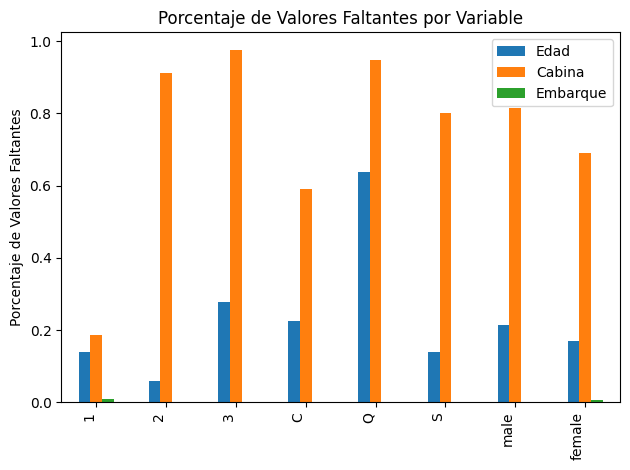

In [197]:
# Totales
totales_prim = df[df['Pclass'] == 1].shape[0]
totales_seg = df[df['Pclass'] == 2].shape[0]
totales_ter = df[df['Pclass'] == 3].shape[0]
totales_C = df[df['Embarked'] == 'C'].shape[0]
totales_Q = df[df['Embarked'] == 'Q'].shape[0]
totales_S = df[df['Embarked'] == 'S'].shape[0]
totales_male = df[df['Sex'] == 'male'].shape[0]
totales_female = df[df['Sex'] == 'female'].shape[0]

# Porcentaje de Edades faltantes
e_f_prim = df[(df['Pclass'] == 1) & (df['Age'].isna())].shape[0] / totales_prim
e_f_seg = df[(df['Pclass'] == 2) & (df['Age'].isna())].shape[0] / totales_seg
e_f_ter = df[(df['Pclass'] == 3)  & df['Age'].isna()].shape[0] / totales_ter
e_f_C = df[(df['Embarked'] == 'C') & df['Age'].isna()].shape[0] / totales_C
e_f_Q = df[(df['Embarked'] == 'Q') & df['Age'].isna()].shape[0] / totales_Q
e_f_S = df[(df['Embarked'] == 'S') & df['Age'].isna()].shape[0] / totales_S
e_f_male = df[(df['Sex'] == 'male') & df['Age'].isna()].shape[0] / totales_male
e_f_female = df[(df['Sex'] == 'female') & df['Age'].isna()].shape[0] / totales_female

# Porcentaje de Cabinas faltantes
c_f_prim = df[(df['Pclass'] == 1) & df['Cabin'].isna()].shape[0] / totales_prim
c_f_seg = df[(df['Pclass'] == 2) & df['Cabin'].isna()].shape[0] / totales_seg
c_f_ter = df[(df['Pclass'] == 3)  & df['Cabin'].isna()].shape[0] / totales_ter
c_f_C = df[(df['Embarked'] == 'C') & df['Cabin'].isna()].shape[0] / totales_C
c_f_Q = df[(df['Embarked'] == 'Q') & df['Cabin'].isna()].shape[0] / totales_Q
c_f_S = df[(df['Embarked'] == 'S') & df['Cabin'].isna()].shape[0] / totales_S
c_f_male = df[(df['Sex'] == 'male') & df['Cabin'].isna()].shape[0] / totales_male
c_f_female = df[(df['Sex'] == 'female') & df['Cabin'].isna()].shape[0] / totales_female

# Porcentaje de Embarque faltante
emb_f_prim = df[(df['Pclass'] == 1) & df['Embarked'].isna()].shape[0] / totales_prim
emb_f_seg = df[(df['Pclass'] == 2) & df['Embarked'].isna()].shape[0] / totales_seg
emb_f_ter = df[(df['Pclass'] == 3)  & df['Embarked'].isna()].shape[0] / totales_ter
emb_f_C = df[(df['Embarked'] == 'C') & df['Embarked'].isna()].shape[0] / totales_C
emb_f_Q = df[(df['Embarked'] == 'Q') & df['Embarked'].isna()].shape[0] / totales_Q
emb_f_S = df[(df['Embarked'] == 'S') & df['Embarked'].isna()].shape[0] / totales_S
emb_f_male = df[(df['Sex'] == 'male') & df['Embarked'].isna()].shape[0] / totales_male
emb_f_female = df[(df['Sex'] == 'female') & df['Embarked'].isna()].shape[0] / totales_female

missing = pd.DataFrame({
    '1': [e_f_prim, c_f_prim, emb_f_prim],
    '2': [e_f_seg, c_f_seg, emb_f_seg],
    '3': [e_f_ter, c_f_ter, emb_f_ter],
    'C': [e_f_C, c_f_C, emb_f_C],
    'Q': [e_f_Q, c_f_Q, emb_f_Q],
    'S': [e_f_S, c_f_S, emb_f_S],
    'male': [e_f_male, c_f_male, emb_f_male],
    'female': [e_f_female, c_f_female, emb_f_female]})
missing.index = ['Edad', 'Cabina', 'Embarque']

plt.figure(figsize=(10, 6))
missing.T.plot(kind='bar')
plt.title('Porcentaje de Valores Faltantes por Variable')
plt.ylabel('Porcentaje de Valores Faltantes')
plt.xticks(ha='right')
plt.tight_layout()
figure_m = plt.gcf()
plt.show()

Variable 'Embarked': \
Dado que para la variable embarque sólo faltan 2 valores, los asociaremos a un error aleatorio (MCAR). De 'Encyclopedia Titanica' obtenemos que los valores faltantes corresponden al puerto de Southampton.

In [198]:
df['Embarked'] = df['Embarked'].fillna(value='S')

Por otro lado, se puede evidenciar en cuanto a clase de tiquete que hay más valores faltantes en tercera clase que en las demás. Además, la segunda y tercera clase casi no tienen registrada la cabina.   
En cuanto a puerto de embarque, se muestra que el puerto que tiene más valores faltantes a comparación con los otros dos es el puerto de Queenstown (Q), pudo suceder que dicho puerto no fue tan riguroso en el registro que los otros dos.
Por tanto, consideramos a la mayoría de los valores faltantes de edad y cabina como productos de errores sistemáticos (MAR).

**Análisis de casos completos vs. incompletos:**

In [199]:
df_c_cabin = df[(df['Cabin'].notna())] # Datos con cabina
total_c_cabin = df_c_cabin.shape[0]
df_s_cabin = df[(df['Cabin'].isna())] # Datos sin cabina
total_s_cabin = df_s_cabin.shape[0]
df_c_age = df[(df['Age'].notna())] # Datos con edad
total_c_age = df_c_age.shape[0]
df_s_age = df[(df['Age'].isna())] # Datos sin edad
total_s_age = df_s_age.shape[0]

Cabina:

<Figure size 1000x600 with 0 Axes>

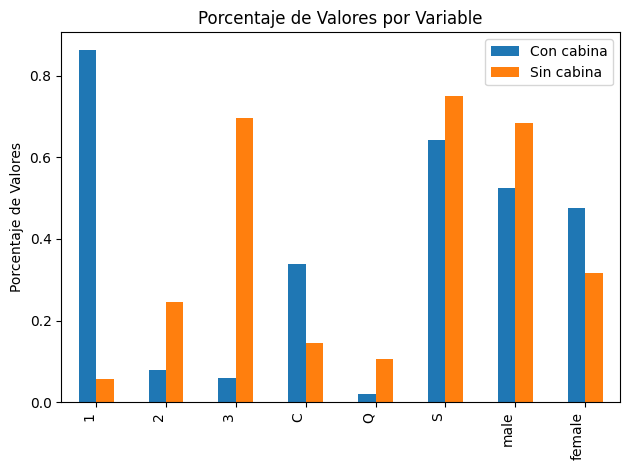

In [200]:
# con Cabina
c_prim = df_c_cabin[df_c_cabin['Pclass'] == 1].shape[0] / total_c_cabin
c_seg = df_c_cabin[df_c_cabin['Pclass'] == 2].shape[0] / total_c_cabin
c_ter = df_c_cabin[df_c_cabin['Pclass'] == 3].shape[0] / total_c_cabin
c_C = df_c_cabin[df_c_cabin['Embarked'] == 'C'].shape[0] / total_c_cabin
c_Q = df_c_cabin[df_c_cabin['Embarked'] == 'Q'].shape[0]  / total_c_cabin
c_S = df_c_cabin[df_c_cabin['Embarked'] == 'S'].shape[0] / total_c_cabin
c_male = df_c_cabin[df_c_cabin['Sex'] == 'male'].shape[0] / total_c_cabin
c_female = df_c_cabin[df_c_cabin['Sex'] == 'female'].shape[0] / total_c_cabin

# sin Cabina
s_prim = df_s_cabin[df_s_cabin['Pclass'] == 1].shape[0] / total_s_cabin
s_seg = df_s_cabin[df_s_cabin['Pclass'] == 2].shape[0] / total_s_cabin
s_ter = df_s_cabin[df_s_cabin['Pclass'] == 3].shape[0] / total_s_cabin
s_C = df_s_cabin[df_s_cabin['Embarked'] == 'C'].shape[0] / total_s_cabin
s_Q = df_s_cabin[df_s_cabin['Embarked'] == 'Q'].shape[0]  / total_s_cabin
s_S = df_s_cabin[df_s_cabin['Embarked'] == 'S'].shape[0] / total_s_cabin
s_male = df_s_cabin[df_s_cabin['Sex'] == 'male'].shape[0] / total_s_cabin
s_female = df_s_cabin[df_s_cabin['Sex'] == 'female'].shape[0] / total_s_cabin

cabin = pd.DataFrame({
    '1': [c_prim, s_prim],
    '2': [c_seg, s_seg],
    '3': [c_ter, s_ter],
    'C': [c_C, s_C],
    'Q': [c_Q, s_Q],
    'S': [c_S, s_S],
    'male': [c_male, s_male],
    'female': [c_female, s_female]})
cabin.index = ['Con cabina', 'Sin cabina']

plt.figure(figsize=(10, 6))
cabin.T.plot(kind='bar')
plt.title('Porcentaje de Valores por Variable')
plt.ylabel('Porcentaje de Valores')
plt.xticks(ha='right')
plt.tight_layout()
figure_cabin = plt.gcf()

Es evidente que la distribución de los datos con cabina y de los datos sin cabina difieren fuertemente en cuanto a la variable clase. \
Como test se compara el valor esperado de la clase:

In [201]:
c_mean = df_c_cabin['Pclass'].mean()
s_mean = df_s_cabin['Pclass'].mean()
print('Con cabina: ', c_mean)
print('Sin cabina: ', s_mean)

Con cabina:  1.196078431372549
Sin cabina:  2.63901018922853


Difieren significativamente para estar acotada por un rango de 1 a 3 \\
Esto implicaría que si a un nuevo dato de clase 1 no posee cabina el modelo lo considere como de clase 3.

Edad:

<Figure size 1000x600 with 0 Axes>

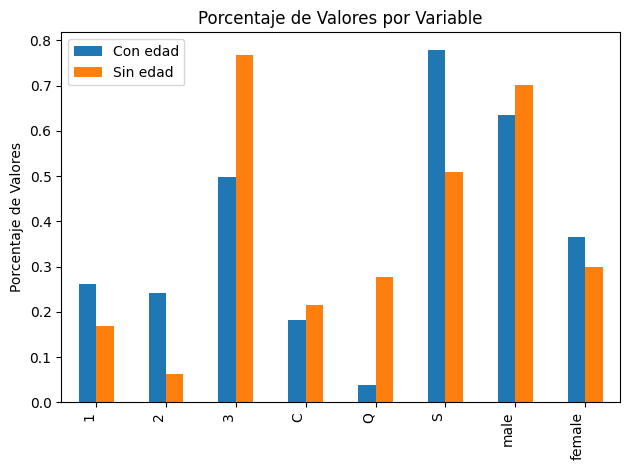

In [202]:
# con edad
c_prim = df_c_age[df_c_age['Pclass'] == 1].shape[0] / total_c_age
c_seg = df_c_age[df_c_age['Pclass'] == 2].shape[0] / total_c_age
c_ter = df_c_age[df_c_age['Pclass'] == 3].shape[0] / total_c_age
c_C = df_c_age[df_c_age['Embarked'] == 'C'].shape[0] / total_c_age
c_Q = df_c_age[df_c_age['Embarked'] == 'Q'].shape[0]  / total_c_age
c_S = df_c_age[df_c_age['Embarked'] == 'S'].shape[0] / total_c_age
c_male = df_c_age[df_c_age['Sex'] == 'male'].shape[0] / total_c_age
c_female = df_c_age[df_c_age['Sex'] == 'female'].shape[0] / total_c_age

# sin edad
s_prim = df_s_age[df_s_age['Pclass'] == 1].shape[0] / total_s_age
s_seg = df_s_age[df_s_age['Pclass'] == 2].shape[0] / total_s_age
s_ter = df_s_age[df_s_age['Pclass'] == 3].shape[0] / total_s_age
s_C = df_s_age[df_s_age['Embarked'] == 'C'].shape[0] / total_s_age
s_Q = df_s_age[df_s_age['Embarked'] == 'Q'].shape[0]  / total_s_age
s_S = df_s_age[df_s_age['Embarked'] == 'S'].shape[0] / total_s_age
s_male = df_s_age[df_s_age['Sex'] == 'male'].shape[0] / total_s_age
s_female = df_s_age[df_s_age['Sex'] == 'female'].shape[0] / total_s_age

age = pd.DataFrame({
    '1': [c_prim, s_prim],
    '2': [c_seg, s_seg],
    '3': [c_ter, s_ter],
    'C': [c_C, s_C],
    'Q': [c_Q, s_Q],
    'S': [c_S, s_S],
    'male': [c_male, s_male],
    'female': [c_female, s_female]})
age.index = ['Con edad', 'Sin edad']

plt.figure(figsize=(10, 6))
age.T.plot(kind='bar')
plt.title('Porcentaje de Valores por Variable')
plt.ylabel('Porcentaje de Valores')
plt.xticks(ha='right')
plt.tight_layout()
figure_age = plt.gcf()

Se puede evidenciar que la distribución de los datos con edad y de los datos sin edad difieren en cuanto a las variables clase y puerto de embarque.

**Correlación con otras variables:**

La ausencia de datos se relaciona con la variable clase y, en menor medida, con la variable puerto de embarque

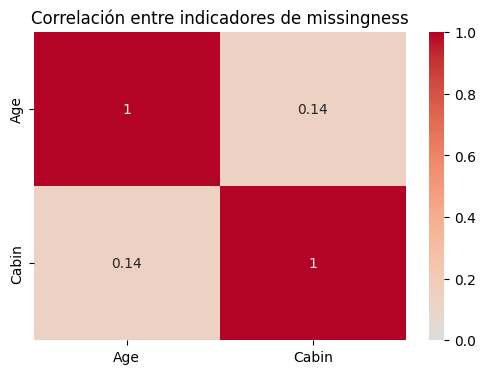

In [203]:
df_ = df[['Age','Cabin']]

missingness = df_.isnull().astype(int)

corr_matrix = missingness.corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, vmin=0, vmax=1)
plt.title("Correlación entre indicadores de missingness")
plt.show()

**Estrategias de Imputación**

Cabina: Dado que a la variable Cabina le hacen falta el 77% de los datos, no se considerará la columna completa. Se eliminará más adelante.

Edad: Se analizan 2 métodos de imputación:
- Método Basado en Grupos: edad promedio por Título
- Método KNN imputer

In [204]:
df_clean = df.copy()
df_clean = df_clean.drop('Cabin', axis=1)

df_grupos = df.copy()

# Basado en grupos
df_grupos['Title'] = df_grupos['Name'].apply(lambda x: re.search(' ([A-Za-z]+)\.', x).group(1))
means = df_grupos.groupby('Title')['Age'].mean()
df_grupos['Age'] = df_grupos.apply(lambda x: np.round(means[x['Title']],0) if np.isnan(x['Age']) else x['Age'], axis=1)
df_grupos = df_grupos.drop('Title', axis=1)

# KNN Imputer
features = ["Age", "Pclass", "SibSp", "Parch", "Fare"]
df_subset = df[features]
imputer = KNNImputer(n_neighbors=5, weights="uniform")
df_imputed = imputer.fit_transform(df_subset)
df_imputed = pd.DataFrame(df_imputed, columns=features)
df_imputed['Age'] = df_imputed['Age'].round()

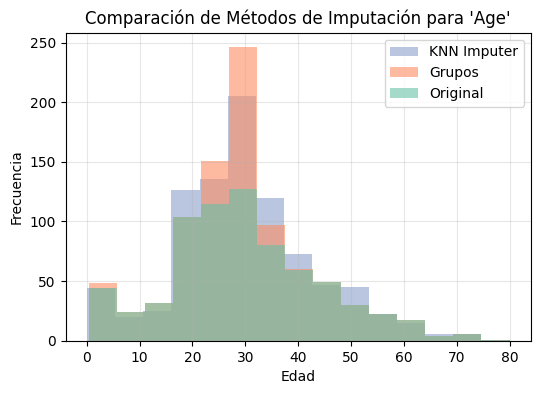

In [205]:
colors = cm.Set2.colors  

fig, ax = plt.subplots(figsize=(6, 4))  

df_imputed['Age'].hist(ax=ax, alpha=0.6, bins=15, label='KNN Imputer', color=colors[2])
df_grupos['Age'].hist(ax=ax, alpha=0.6, bins=15, label='Grupos', color=colors[1])
df_clean['Age'].hist(ax=ax, alpha=0.6, bins=15, label='Original', color=colors[0])

ax.set_title("Comparación de Métodos de Imputación para 'Age'", fontsize=12)
ax.set_xlabel("Edad")
ax.set_ylabel("Frecuencia")
ax.legend()
ax.grid(alpha=0.3)

plt.show()

KNN imputer es un poquito más próximo a la distribución original.

In [206]:
df["Age"] = df_imputed["Age"]
df["Age"].isna().sum()

np.int64(0)

# Ingenieria de Features

Se plantean 10 nuevos feutures que permitiran cuntificar variables no numericas, las cuales permitiran y facilitaran analisis. Se platean la siguientes:

**Title:** Es el titulo honorifico de cada pasajero.(str)

**FamiliSize:** Tamaño de la familia. (int)

**IsAlone:** 0 si viajaba solo, 1 si no.

**AgeGroup:** Se categorizó segun la edad, "Infant"(0-12) años, "Teenager" (13-18) años, "Adult" (19-64)años y "Third age" (mayor de 65 años).

**FarePerPerson:** Se encontro el costo del ticket individual.

**IsMother:** 1 si es madre, 0 si no.

**FareAboveMedian:** 1 si el precio del tiket esta por ensima de la media, 0 si no.

**FamilySurvivalID:** Agrupa a los pasajeros que compartían el billete o apellido.

**LastName:** El apellido del pasajero.

**CabinKnown:** 1 si se conoce la cabina, 0 si no.


In [207]:
#Funciones auxiliares
def get_age_group(age):
    """Asigna la edad a un grupo en epecifico

    Args:
        age (int): Edad

    Returns:
        categoria
    """
    if pd.isnull(age):
      return 'Unknown'
    elif age <= 12:
      return 'Infant'
    elif age <= 18:
      return 'Teenager'
    elif age <= 64:
      return 'Adult'
    else:
      return 'Third age'

In [208]:
titanic_procesado = df.copy()
titanic_procesado['Title'] = titanic_procesado['Name'].apply(lambda x: re.search(r' ([A-Za-z]+)\.', x).group(1))
titanic_procesado['FamilySize'] = titanic_procesado['SibSp'] + titanic_procesado['Parch'] + 1
titanic_procesado['IsAlone'] = (titanic_procesado['FamilySize'] == 1).astype(int)
titanic_procesado['AgeGroup'] = titanic_procesado['Age'].apply(get_age_group)
titanic_procesado['IsMother'] = ((titanic_procesado['Sex'] == 'female') &
                      (titanic_procesado['Age'] >= 16) &  # Madres más jóvenes
                      (titanic_procesado['Parch'] > 0) &
                      ((titanic_procesado['SibSp'] > 0) | (titanic_procesado['Parch'] > 1)) &  # Más evidencia familiar
                      (~titanic_procesado['Title'].isin(['Miss', 'Ms']))).astype(int)  # Excluir solteras
titanic_procesado['FareAboveMedian'] = (titanic_procesado['Fare'] > titanic_procesado['Fare'].mean()).astype(int)
titanic_procesado['FarePerPerson'] = titanic_procesado['Fare'] / (titanic_procesado.groupby('Ticket')['PassengerId'].transform('count'))
titanic_procesado['FamilySurvivalID'] = titanic_procesado['Ticket'].astype(str) + '_' + titanic_procesado['Name'].str.split(',').str[0]
titanic_procesado['LastName'] = titanic_procesado['Name'].str.split(',').str[0]
titanic_procesado['CabinKnown'] = titanic_procesado['Cabin'].notna().astype(int)
titanic_procesado.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Title,FamilySize,IsAlone,AgeGroup,IsMother,FareAboveMedian,FarePerPerson,FamilySurvivalID,LastName,CabinKnown
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,Mr,2,0,Adult,0,0,7.2500,A/5 21171_Braund,Braund,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,Mrs,2,0,Adult,0,1,71.2833,PC 17599_Cumings,Cumings,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,Miss,1,1,Adult,0,0,7.9250,STON/O2. 3101282_Heikkinen,Heikkinen,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,Mrs,2,0,Adult,0,1,26.5500,113803_Futrelle,Futrelle,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,Mr,1,1,Adult,0,0,8.0500,373450_Allen,Allen,0


In [209]:
warnings.filterwarnings("ignore")

# Calcular correlación de cada variable con Survived
survived_corr = {}

for column in titanic_procesado.columns:
    if column != 'Survived':
        with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
            corr_value = titanic_procesado[[column, 'Survived']].phik_matrix().iloc[0, 1]
        survived_corr[column] = corr_value

# Crear DataFrame ordenado
correlation_df = pd.DataFrame.from_dict(survived_corr, orient='index', 
                                       columns=['Correlation_with_Survived'])
correlation_df = correlation_df.sort_values('Correlation_with_Survived', 
                                           ascending=False)

print("Correlación de cada variable con Survived:")
correlation_df

Correlación de cada variable con Survived:


,Correlation_with_Survived
Name,1.000000
Ticket,0.773153
Sex,0.750322
FamilySurvivalID,0.748386
LastName,0.682088
Title,0.626918
Cabin,0.625486
CabinKnown,0.471466
FareAboveMedian,0.367287
FarePerPerson,0.310500


In [210]:
warnings.filterwarnings("ignore")
def check_leakage(variable, target='Survived', threshold=0.7):
    """
    Detecta posible leakage si la variable tiene correlación muy alta
    y muchos valores únicos
    """
    if variable not in titanic_procesado.columns or variable == target:
        return False
        
    # Verificar que la variable tenga al menos 2 valores únicos
    if titanic_procesado[variable].nunique() < 2:
        print(f"{variable}: Solo 1 valor único → Saltar")
        return False
        
    try:
        # Calcular correlación con manejo de errores
        with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
            corr = titanic_procesado[[variable, target]].phik_matrix().iloc[0, 1]
        
        # Verificar unicidad
        uniqueness = titanic_procesado[variable].nunique() / len(titanic_procesado)
        
        # Criterio de leakage
        is_leakage = (corr > threshold) and (uniqueness > 0.5)
        
        print(f"{variable}: Corr={corr:.3f}, Unicidad={uniqueness:.3f} → {'LEAKAGE' if is_leakage else 'OK'}")
        
        return is_leakage
        
    except Exception as e:
        print(f"{variable}: Error en cálculo → {str(e)[:50]}...")
        return False

suspicious_vars = [col for col in titanic_procesado.columns if col != 'Survived']

print("Análisis de Data Leakage:")
print("=" * 50)

for var in suspicious_vars:
    check_leakage(var)

Análisis de Data Leakage:
PassengerId: Corr=0.141, Unicidad=1.000 → OK
Pclass: Corr=0.205, Unicidad=0.003 → OK
Name: Corr=1.000, Unicidad=1.000 → LEAKAGE
Sex: Corr=0.750, Unicidad=0.002 → OK
Age: Corr=0.207, Unicidad=0.080 → OK
SibSp: Corr=0.176, Unicidad=0.008 → OK
Parch: Corr=0.147, Unicidad=0.008 → OK
Ticket: Corr=0.773, Unicidad=0.764 → LEAKAGE
Fare: Corr=0.265, Unicidad=0.278 → OK
Cabin: Corr=0.625, Unicidad=0.165 → OK
Embarked: Corr=0.099, Unicidad=0.003 → OK
Title: Corr=0.627, Unicidad=0.019 → OK
FamilySize: Corr=0.287, Unicidad=0.010 → OK
IsAlone: Corr=0.306, Unicidad=0.002 → OK
AgeGroup: Corr=0.167, Unicidad=0.004 → OK
IsMother: Corr=0.169, Unicidad=0.002 → OK
FareAboveMedian: Corr=0.367, Unicidad=0.002 → OK
FarePerPerson: Corr=0.310, Unicidad=0.278 → OK
FamilySurvivalID: Corr=0.748, Unicidad=0.829 → LEAKAGE
LastName: Corr=0.682, Unicidad=0.749 → OK
CabinKnown: Corr=0.471, Unicidad=0.002 → OK


Con este analisis evidensiamos datos que son unicos como lo son el nombre, el ticket y el FamilySurvivalID que envista que son unicos al momento de implementar un modelo de maching learning puede perjudicar la capacidad de predicción ya que memozaria patrones muy fuertes que sesgaria su elección.

In [211]:
variables_leakage = ['Name', 'Ticket', 'FamilySurvivalID']
correlation_df = correlation_df[~correlation_df.index.isin(variables_leakage)]

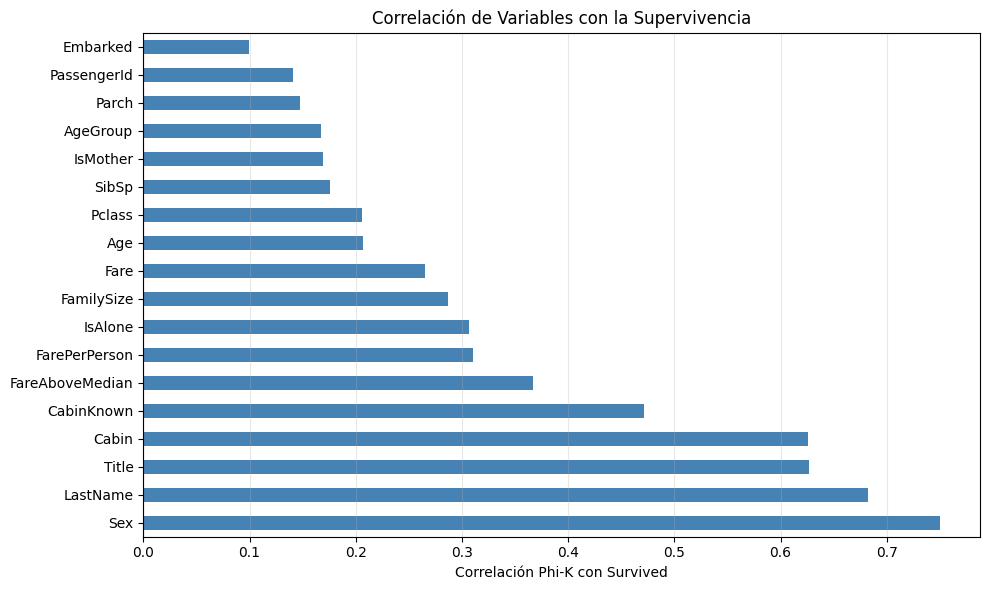

In [212]:
plt.figure(figsize=(10, 6))
correlation_df['Correlation_with_Survived'].plot(kind='barh', color='steelblue')
plt.xlabel('Correlación Phi-K con Survived')
plt.title('Correlación de Variables con la Supervivencia')
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Análisis y mitigación de sesgos

In [213]:
def safe_chi2(tab_values):
    if np.any(tab_values.sum(axis=0) == 0) or np.any(tab_values.sum(axis=1) == 0):
        return 1.0
    chi2, p, dof, exp = chi2_contingency(tab_values)
    return 1.0 if np.any(exp == 0) else p

def missingness_by_group(df, col, group_col):
    x = df[[col, group_col]].copy()
    x["is_missing"] = x[col].isna().astype(int)
    tab = pd.crosstab(x[group_col], x["is_missing"])
    for k in [0,1]:
        if k not in tab.columns:
            tab[k] = 0
    p = safe_chi2(tab.values)
    rates = x.groupby(group_col)["is_missing"].mean()
    return rates, p

# Tabla general de faltantes
miss_overall = df.isna().sum().to_frame("missing_count")
miss_overall["missing_%"] = (df.isna().mean()*100).round(2)
print(miss_overall.sort_values("missing_%", ascending=False).head(5))

# Sesgo por supervivencia
rows = []
for col in df.columns:
    if col == "Survived": continue
    rates, p = missingness_by_group(df, col, "Survived")
    rows.append({"column": col, "rate_dead": float(rates.get(0, np.nan)),
                 "rate_survived": float(rates.get(1, np.nan)), "p_value": p})
miss_vs_survived = pd.DataFrame(rows).sort_values("p_value")
print(miss_vs_survived.head())

# Sesgo por clase
rows = []
for col in df.columns:
    if col in ["Survived","Pclass"]: continue
    rates, p = missingness_by_group(df, col, "Pclass")
    rows.append({"column": col, "rate_P1": float(rates.get(1, np.nan)),
                 "rate_P2": float(rates.get(2, np.nan)),
                 "rate_P3": float(rates.get(3, np.nan)), "p_value": p})
miss_vs_pclass = pd.DataFrame(rows).sort_values("p_value")
print(miss_vs_pclass.head())

# Sesgo por género
rows = []
for col in df.columns:
    if col in ["Survived","Sex"]: continue
    rates, p = missingness_by_group(df, col, "Sex")
    rows.append({"column": col, "rate_female": float(rates.get("female", np.nan)),
                 "rate_male": float(rates.get("male", np.nan)), "p_value": p})
miss_vs_sex = pd.DataFrame(rows).sort_values("p_value")
print(miss_vs_sex.head())

             missing_count  missing_%
Cabin                  687       77.1
PassengerId              0        0.0
Pclass                   0        0.0
Survived                 0        0.0
Name                     0        0.0
        column  rate_dead  rate_survived       p_value
9        Cabin   0.876138       0.602339  6.741970e-21
0  PassengerId   0.000000       0.000000  1.000000e+00
2         Name   0.000000       0.000000  1.000000e+00
1       Pclass   0.000000       0.000000  1.000000e+00
4          Age   0.000000       0.000000  1.000000e+00
        column   rate_P1   rate_P2  rate_P3        p_value
8        Cabin  0.185185  0.913043  0.97556  9.585484e-122
0  PassengerId  0.000000  0.000000  0.00000   1.000000e+00
2          Sex  0.000000  0.000000  0.00000   1.000000e+00
1         Name  0.000000  0.000000  0.00000   1.000000e+00
4        SibSp  0.000000  0.000000  0.00000   1.000000e+00
        column  rate_female  rate_male  p_value
8        Cabin     0.691083   0.814558  

**Sesgo de supervivencia**

Cabin: 87.6% de los no sobrevivientes no tienen dato vs 60.2% de los sobrevivientes (p ≈ 6.7e-21, muy significativo).

Age: 22.8% faltante en no sobrevivientes vs 15.2% en sobrevivientes (p ≈ 0.0077, también significativo).

Conclusión: hay información sistemáticamente faltante en los no sobrevivientes, sobre todo en Cabin y Age, lo cual puede sesgar el análisis si no se imputa adecuadamente.

**Sesgo de clase social**

Cabin: en 1ª clase solo falta 18.5%, pero en 2ª falta 91.3% y en 3ª 97.6% (p ≈ 9.6e-122).

Age: faltantes más altos en 3ª clase (27.7%) que en 1ª (13.9%) y 2ª (6.0%) (p ≈ 9.9e-11).

Conclusión: la calidad de datos es muy desigual según la clase social, siendo los pasajeros de 3ª los más afectados. Esto refleja un sesgo de clase: peor información en clases bajas.

**Sesgo de género**

Cabin: 81.5% de los hombres sin dato vs 69.1% de las mujeres (p ≈ 4e-5, significativo).

Age: hombres con 21.5% faltante vs mujeres 16.9%, pero la diferencia no es estadísticamente significativa (p ≈ 0.12).

Conclusión: los hombres tienen más datos faltantes en Cabin. En Age parece haber una tendencia, pero no significativa.

**Sesgo histórico (subrepresentación)**

De tu tabla de representación (Sex × Pclass × Embarked, que también calculamos antes):

Hay grupos muy pequeños, por ejemplo: mujeres de 1ª clase que embarcaron en Q (solo 1 pasajera, 0.11% del dataset).

Esto significa que ciertos subgrupos están subrepresentados y cualquier métrica de fairness que se calcule sobre ellos tendrá mucha varianza.

 Conclusión: existe subrepresentación histórica de ciertos perfiles (clase alta, puerto Q, mujeres solas, etc.), lo que limita la generalización de los análisis.

# Dataset procesado

Utilizaremos solo las variables 'Age', 'Pclass' y 'Sex'. Además de los features 'CabinKnown' y 'FareAboveMedian'.

Se usa one-hot encoding para las variables 'Pclass' y 'Sex'.

In [215]:
titanic_procesado = titanic_procesado[['Age', 'Pclass','Sex', 'CabinKnown', 'FareAboveMedian']]
df_ = pd.get_dummies(titanic_procesado, columns=['Pclass', 'Sex'], drop_first=True)
df_ = df_[['Age', 'Pclass_2', 'Pclass_3', 'Sex_male']].astype(int)
df_['CabinKnown'] = titanic_procesado['CabinKnown']
df_['FareAboveMedian'] = titanic_procesado['FareAboveMedian']
df_

,Age,Pclass_2,Pclass_3,Sex_male,CabinKnown,FareAboveMedian
0,22,0,1,1,0,0
1,38,0,0,0,1,1
2,26,0,1,0,0,0
3,35,0,0,0,1,1
4,35,0,1,1,0,0
...,...,...,...,...,...,...
886,27,1,0,1,0,0
887,19,0,0,0,1,0
888,27,0,1,0,0,0
889,26,0,0,1,1,0


In [216]:
df_.to_csv(r"..\data\processed.csv", index=False)